<a href="https://colab.research.google.com/github/zhus-dika/math_home_works/blob/main/hw03_A_B_test_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<img src="https://camo.githubusercontent.com/ad20aaaa48264581c46aa126919dbb72060ebd98cffe015523549b4974843ae5/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f46556c79616e6b696e2f725f70726f626162696c6974792f6d61737465722f656e645f73656d696e6172732f73656d5f362f73747564656e745f746561636865725f646973742e706e67" height="200">

# Прикладаная статистика: домашнее задание 3
</center>

> Если орел — я выиграла, если решка — ты проиграл.

$\qquad$ Рейчел из друзей


**ФИО:**


## Общая информация


__Дата выдачи:__ 24.05.2023

__Дедлайн:__ 23:59MSK 11.06.2023

# Результаты A-B теста

В данном задании вам нужно будет проанализировать АБ тест, проведенный на реальных пользователях Яндекса.

### Описание данных:

* `userID` — уникальный идентификатор пользователя
* `browser` — браузер, который использовал userID
* `slot` — в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
* `n_clicks` — количество кликов, которые пользователь совершил за n_queries
* `n_queries` — количество запросов, который совершил userID, пользуясь браузером browser
* `n_nonclk_queries` — количество запросов пользователя, в которых им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats as sts
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('ab_browser_test.csv',sep=',')

df['click_per_queries'] = df['n_clicks']/df['n_queries']
df['empty_query_share'] = df['n_nonclk_queries']/df['n_queries']

print(df.shape)
df.head()

(566134, 8)


,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries,click_per_queries,empty_query_share
0,1,Browser #2,exp,23,32,19,0.718750,0.593750
1,3,Browser #4,exp,3,4,2,0.750000,0.500000
2,5,Browser #4,exp,29,35,16,0.828571,0.457143
3,6,Browser #4,control,12,6,0,2.000000,0.000000
4,7,Browser #4,exp,54,68,30,0.794118,0.441176


Будем работать с числом кликов на количество пользовательских сессий.

> Вообще, это ratio-метрика. Из-за этого у неё будут довольно тяжёлые хвосты. Мы увидим это ниже в пункте про бутстрэп. И к ней нужен особый подход, о котором мы поговорим на лекции. Пока что будем это игнорировать. В целом, можно откатиться к кликам и работать с их средним, но методологически правильнее отнормировать их на число сессий.

__[10 баллов]__ Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

In [3]:
df_exp = df[df.slot == 'exp']
df_control = df[df.slot == 'control']

In [4]:
(df_exp.click_per_queries.sum() / df_control.click_per_queries.sum() - 1) * 100

6.370810389121129

Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

## Часть 1: анализ АБ-теста

__[10 баллов]__ Давайте внимательнее посмотрим на то, что происходит с кликами в наших пользовательских сессиях. Постройте для контрольной и тестовой групп визуализации и ответьте на следующие вопросы.

- Правда ли, что в данных есть много выбросов?
- Правда ли, что данные пришли из одного распределения и в группах отличия только в сдвиге (для ответа на этот вопрос постройте для обеих групп квантили распределений с шагом в 0.1 и сравните их между собой + сравните гистограмы по форме)
- Как думаете, какие тесты применимы здесь для проведения АБ?

**Ответы:**

🦒 Да, действительно выбросов много, графически это можно заметить на графиках сравнения релплотов.

🦤 Да, согласно графикам для квантилей, можно увидеть небольшой сдвиг вверх для переменной `click_per_queries` в экспериментольной группе.

🪲 z-тест не подойдет, потому, что он плохо работает с данными, которые содержат много выбросов. Можно попробовать критерий Манна-Уитни.

In [5]:
df.describe()

,userID,n_clicks,n_queries,n_nonclk_queries,click_per_queries,empty_query_share
count,566134.000000,566134.000000,566134.000000,566134.000000,566134.000000,566134.000000
mean,301377.214027,11.431658,10.720524,4.703987,1.043577,0.435719
std,175526.333101,20.251494,16.262827,8.109958,1.029891,0.330016
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,148627.250000,1.000000,2.000000,1.000000,0.500000,0.166667
50%,299362.500000,4.000000,5.000000,2.000000,1.000000,0.416667
75%,455698.750000,13.000000,13.000000,6.000000,1.333333,0.666667
max,603137.000000,863.000000,665.000000,581.000000,60.000000,1.000000


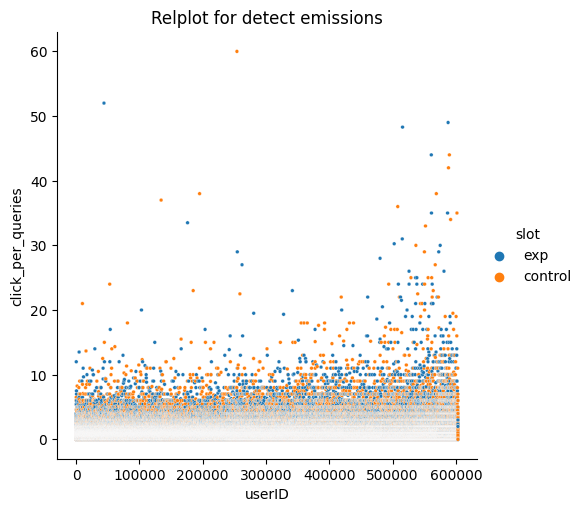

In [6]:
sns.relplot(data=df, x='userID', y='click_per_queries', hue='slot', s=7)
plt.title(f'Relplot for detect emissions')
plt.xlabel('userID')
plt.ylabel('click_per_queries')
sns.set_style("ticks",{'axes.grid' : True})

In [7]:
click_per_queries_quantiles = {'exp': [], 'control': []}

for i in range(100):
  click_per_queries_quantiles['exp'].append(df_exp.click_per_queries.quantile(0.01 * i))
  click_per_queries_quantiles['control'].append(df_control.click_per_queries.quantile(0.01 * i))

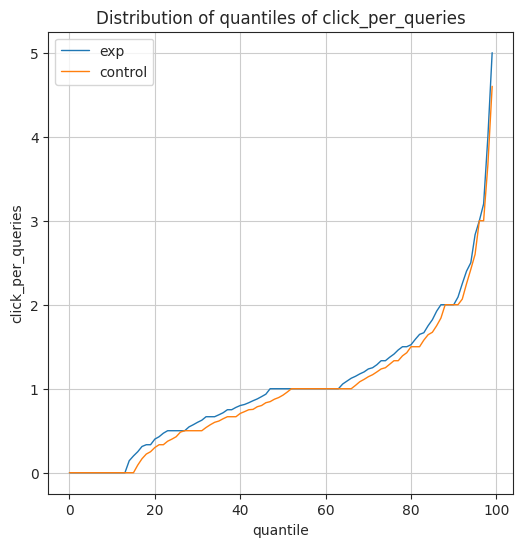

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(click_per_queries_quantiles['exp'], label="exp", linewidth=1)
ax.plot(click_per_queries_quantiles['control'], label="control", linewidth=1)
ax.legend()
plt.title(f'Distribution of quantiles of click_per_queries')
plt.xlabel('quantile')
plt.ylabel('click_per_queries')
plt.show()

__[10 баллов]__ Скорее всего, в пункте выше вы написали, что $z$-тест нам не подходит из-за выбросов. Однако, мы не можем наверняка знать, насколько серьёзное влияние эти выбросы оказали на ЦПТ и сломали ли они её. Если посчитать по выброкам средние и медианы, они окажутся очень похожими.

Бутстрап — это асимптотическая техника для получения критических значений статистики. Давайте проведём следующую процедуру. Ограничимся в рамках неё контрольной группой. Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстрэп, чтобы понять, как распределена z-статистика и сравнить её распределение с нормальным.

Поскольку мы знаем, что $\text{Var}(\bar X_n) = \frac{\sigma^2}{n}$, нам не надо будет делать бутстрэп в бутстрэпе. Когда мы знаем для нашей статистики форму дисперсии, бутстрэп называется __параметрическим.__

1. Получите из данных `n_boot_samples` псевдовыборок,
2. По каждой из этих выборок посчитайте среднее и его дисперсию,
3. Рассчитайте значение $z$-статистики,
4. Для получившегося вектора из $z$-статистик постройте `qq-plot` с помощью ` scipy.stats.probplot` для нормального распределения.

Сделайте выводы.

In [9]:
df_exp.describe()

,userID,n_clicks,n_queries,n_nonclk_queries,click_per_queries,empty_query_share
count,281580.000000,281580.000000,281580.000000,281580.000000,281580.000000,281580.000000
mean,301287.262867,11.584001,10.591793,4.522576,1.081474,0.418480
std,175500.838891,20.219494,15.951039,7.816162,1.040727,0.326366
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,148513.500000,1.000000,2.000000,1.000000,0.500000,0.142857
50%,299057.000000,5.000000,5.000000,2.000000,1.000000,0.400000
75%,455684.500000,13.000000,13.000000,5.000000,1.375000,0.625000
max,603137.000000,776.000000,665.000000,581.000000,52.000000,1.000000


In [10]:
df_control.describe()

,userID,n_clicks,n_queries,n_nonclk_queries,click_per_queries,empty_query_share
count,284554.000000,284554.000000,284554.000000,284554.000000,284554.000000,284554.000000
mean,301466.225068,11.280906,10.847909,4.883502,1.006076,0.452779
std,175551.820225,20.282018,16.564624,8.386714,1.017668,0.332712
min,6.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,148725.250000,1.000000,2.000000,1.000000,0.428571,0.200000
50%,299620.500000,4.000000,5.000000,2.000000,0.923077,0.444444
75%,455704.500000,13.000000,13.000000,6.000000,1.291667,0.666667
max,603136.000000,863.000000,435.000000,386.000000,60.000000,1.000000


In [11]:
def get_bootstrap_sample(x, B_sample=1):
  n = x.size
  sample = np.random.choice(x, size=(n, B_sample), replace=True)
  if B_sample == 1:
    sample = sample.T[0]
  return sample

In [12]:
n_boot_samples = 1000
exp_boot = get_bootstrap_sample(df_exp.click_per_queries, B_sample=n_boot_samples)
mean_exp_boot = np.mean(exp_boot, axis=0)
var_exp_boot = np.var(exp_boot, axis=0, ddof=1)

control_boot = get_bootstrap_sample(df_control.click_per_queries, B_sample=n_boot_samples)
mean_control_boot = np.mean(control_boot, axis=0)
var_control_boot = np.var(control_boot, axis=0, ddof=1)

In [13]:
def stat_intervals(boot, alpha=0.05):
  left = np.quantile(boot, alpha / 2)
  right = np.quantile(boot, 1 - alpha / 2)
  return left, right

In [14]:
stat_intervals(mean_exp_boot)

(1.0775163489781614, 1.0852382460278356)

In [15]:
stat_intervals(mean_control_boot)

(1.0022556827893505, 1.0098850374190382)

In [16]:
stat_intervals(mean_exp_boot - mean_control_boot)

(0.07001817811411316, 0.08061420062691216)

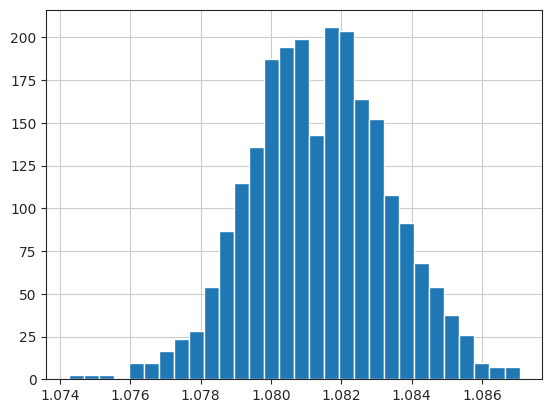

In [17]:
plt.hist(mean_exp_boot, bins=30, density=True);
sns.set_style("ticks",{'axes.grid' : True})

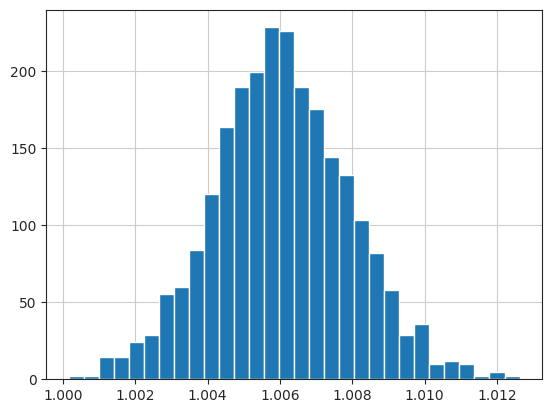

In [18]:
plt.hist(mean_control_boot, bins=30, density=True);

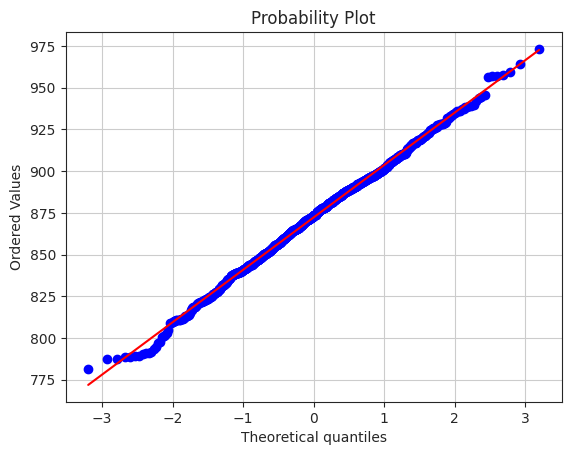

In [19]:
x = mean_exp_boot
y = mean_control_boot
n = x.shape[0]
var_hat_x = x.var(ddof=1)
var_hat_y = y.var(ddof=1)
zstat = (mean_exp_boot - mean_control_boot) / np.sqrt((var_hat_x + var_hat_y) / n)
sts.probplot(zstat, plot=plt);

__[10 баллов]__ Осторожно, спойлеры! В прошлом пункте у вас получилась картинка, на которой хвосты распределения немного отличаются от стандартного нормального. Давайте сделаем вид, что всё хорошо и отличия на хвостах нет. Проверьте гипотезу о равенстве средних между группами с помощью $z-$теста на уровне значимости $1\%$.

In [20]:
from statsmodels.stats.weightstats import ztest,zconfint

alpha = 0.01
left, right = zconfint(x, y, alpha=alpha)
print('conf interval:', left, right)
stat, pvalue = ztest(x, y)
print('zstat:',stat, '\npvalue:',pvalue)

conf interval: 0.07511663882240364 0.07556160342237313
zstat: 872.2523809938046 
pvalue: 0.0


🐫 Гипотеза отвергается, потому что `pvalue < alpha`.

__[10 баллов]__ Давайте попробуем понять, какими при таких объёмах выборки оказываются MDE и ошибка второго рода. Конечно, же сделать это надо до проведения АБ-теста. Но не мы его готовили... При решении этого пункта выберите какое-то адекватное значение MDE и получите отталкиваясь от него ошибку второго рода.

Формула для расчета числа наблюдений __для одной группы:__

$$
n_{\text{one group}} = \frac{(\sigma_A^2 + \sigma_B^2) \cdot (z_{1-\frac{\alpha}{2}} + z_{1-\beta})^2}{MDE^2},
$$

In [21]:
from statsmodels.stats.power import zt_ind_solve_power

MDE_val = 0.012
alpha = 0.01
n = df_exp.click_per_queries.shape[0]
print(f"""
zt_ind_solve_power beta: {1 - zt_ind_solve_power(effect_size=MDE_val, nobs1=n, ratio=1, alpha=alpha)}
""")


zt_ind_solve_power beta: 0.027001661224096307



__[10 баллов]__ Хвосты отличаются от стандартного нормального. По хорошему, для проверки гипотезы нужно использовать бутстрап. В контексте средних, на бутстрап можно смотреть как на технику, которая уточняет, насколько сильно хвосты распределения стали тяжелее по сравнению с ЦПТ.

Проверьте гипотезу с помощью бутстрапа! Воспользуйтесь следующим алгоритмом с лекции:

1. Посчитайте наблюдаемое значение статистики.
2. Пусть $\bar h$ - это среднее посчитанное по обеим выборкам вместе. Создайте две новые выборки $$x'_i = x_i - \bar x + \bar h \\ y'_i = y_i - \bar y + \bar h.$$ Такое рецентрирование сдвинет обе выборки к общему среднему и  позволит заложить в симуляцию информацию о верности нулевой гипотезы.
3. Сбутстрапируйте выборки $x^{*}$ и $y^{*}$ из $x'$ и $y'$. Рассчитайте значение z-статистики. Повторите процедуру $B$ раз.
4. Для оценки `p-value` воспользуйтесь формулой:

$$
2 * \frac{1}{B} \sum_{i=1}^B [z_i^{*} \ge z_{obs}]
$$

In [22]:
x = df_exp.click_per_queries
y = df_control.click_per_queries
n = x.shape[0]
m = y.shape[0]
mean_hat_x = np.mean(x)
mean_hat_y = np.mean(y)
var_hat_x = x.var(ddof=1)
var_hat_y = y.var(ddof=1)
zobs = (mean_hat_x - mean_hat_y) / np.sqrt(var_hat_x / n + var_hat_y / m)
print('Наблюдаемое значение статистики:', zobs)

Наблюдаемое значение статистики: 27.55706066913807


In [23]:
h_mean = np.mean(np.concatenate((x, y), axis=0))

In [24]:
x_prime = x - np.mean(x) + h_mean
y_prime = y - np.mean(y) + h_mean

🦊 Посчитаем статистику для центрированных выборок  `x_prime, y_prime`:

In [25]:
x = x_prime
y = y_prime
n = x.shape[0]
m = y.shape[0]
mean_hat_x = np.mean(x)
mean_hat_y = np.mean(y)
var_hat_x = x.var(ddof=1)
var_hat_y = y.var(ddof=1)
zobs = (mean_hat_x - mean_hat_y) / np.sqrt(var_hat_x / n + var_hat_y / m)
print('Наблюдаемое значение статистики центрированных выборок:', zobs)

Наблюдаемое значение статистики центрированных выборок: -8.115443577464868e-14


🫏 Забутстрапируем выборки `x_prime, y_prime`:

In [26]:
B = 1000
exp_boot = get_bootstrap_sample(x_prime, B_sample=B)
mean_exp_boot = np.mean(exp_boot, axis=0)
var_exp_boot = np.var(exp_boot, axis=0, ddof=1)

control_boot = get_bootstrap_sample(y_prime, B_sample=B)
mean_control_boot = np.mean(control_boot, axis=0)
var_control_boot = np.var(control_boot, axis=0, ddof=1)

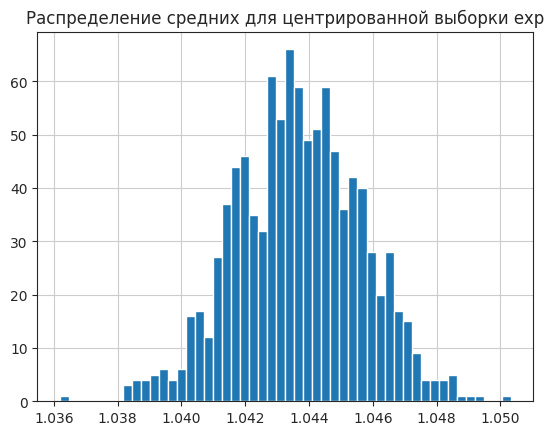

In [27]:
plt.hist(mean_exp_boot, bins=50);
plt.title('Распределение средних для центрированной выборки exp');

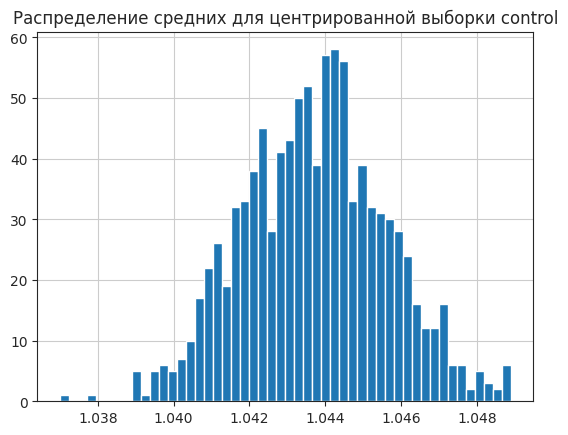

In [28]:
plt.hist(mean_control_boot, bins=50);
plt.title('Распределение средних для центрированной выборки control');

In [29]:
zstat = (mean_exp_boot - mean_control_boot) / np.sqrt((var_exp_boot + var_control_boot) / B)
pval = 2 / B * sum(zstat > zobs)
pval

1.012

🐦 Так как `pval > alpha`, гипотеза не отвергается.

🦋 Здесь использовала материалы из статьи https://habr.com/ru/companies/X5Tech/articles/679842/

In [30]:
def get_normal_ci(bootstrap_stats, stat, alpha):
    """Строит нормальный доверительный интервал."""
    z = sts.norm.ppf(1 - alpha / 2)
    se = np.std(bootstrap_stats)
    left, right = stat - z * se, stat + z * se
    return left, right

def get_efron_ci(bootstrap_stats, stat, alpha):
    """Строит Эфронов перцентильный доверительный интервал."""
    left, right = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
    return left, right

def get_pivotal_ci(bootstrap_stats, stat, alpha):
    """Строит центральный доверительный интервал."""
    left, right= 2 * stat - np.quantile(bootstrap_stats, [1 - alpha / 2,  alpha / 2])
    return left, right

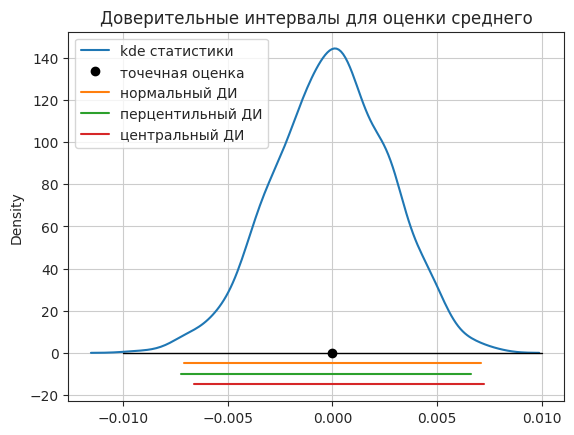

In [31]:
normal_ci = get_normal_ci(mean_exp_boot - mean_control_boot, zobs, alpha)
percentile_ci = get_efron_ci(mean_exp_boot - mean_control_boot, zobs, alpha)
pivotal_ci = get_pivotal_ci(mean_exp_boot - mean_control_boot, zobs, alpha)

sns.kdeplot(mean_exp_boot - mean_control_boot, label='kde статистики')
plt.plot([zobs], [0], 'o', c='k', markersize=6, label='точечная оценка')
plt.plot([-0.01, 0.01], [0, 0], 'k', linewidth=1)
d = 5
plt.plot(normal_ci, [-d, -d], label='нормальный ДИ')
plt.plot(percentile_ci, [-d*2, -d*2], label='перцентильный ДИ')
plt.plot(pivotal_ci, [-d*3, -d*3], label='центральный ДИ')

plt.title('Доверительные интервалы для оценки среднего')
plt.legend()
plt.show()

In [32]:
stat, pvalue = ztest(mean_exp_boot - mean_control_boot)
print('zstat:',stat, '\npvalue:',pvalue)

zstat: -0.5413251033265083 
pvalue: 0.5882835206106058


In [41]:
normal_ci

(-0.00707875718224482, 0.00707875718208251)

In [42]:
percentile_ci

(-0.007230016100233933, 0.006597609236068413)

__Ответьте на следующие вопросы:__

- Изменились ли выводы АБ-теста?
- Насколько сильно критическое значение статистики, полученной с помощью бутстрэпа, отличается от критческого значения нормального распределения?
- Какую из ошибок (1 рода/2 рода) вы будете чаще совершать, если в ситуации с толстыми хвостами будете пользоваться нормальным распределением? Насколько чаще будет возникать эта ошибка?

**Ответы**

💐 Да, во втором эксперименте А/Б теста мы получаем оценку положительную и гипотеза не отвергается. Центрирование помогло понизить тяжелые хвосты в распределении средних с помощью бутстрэпа.

🌴 Критические значения значительно близки, доверительные интервалы (ДИ) `normal_ci` и `percentile_ci` с незначительным отклонением почти равны.

🌹 Если хвосты толстые у распределения, то совершать будем больше ошибку 2-го рода, т.к. для заданного значения `alpha` критические значения будут лежать дальше от среднего значения, поэтому область красная на картинке будет увеличиваться с движением зеленой линии вправо.

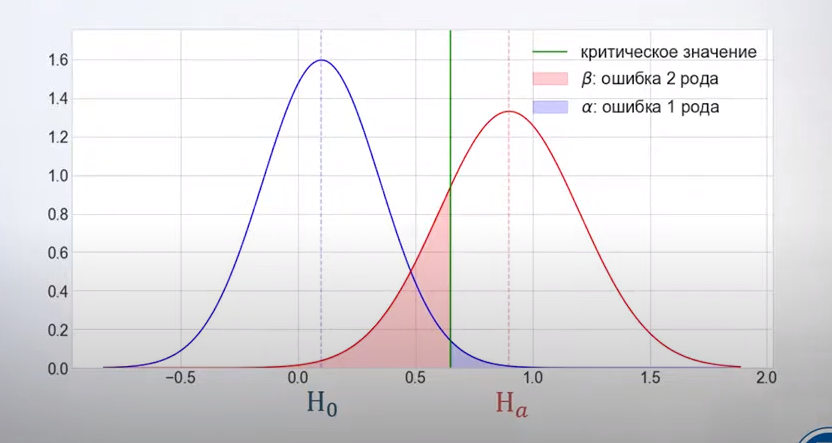

__[10 баллов]__ Насколько больше наблюдений нам необходимо для проверки гипотезы по сравнению с z-тестом? Для ответа на этот вопрос подставьте критические значение из бустрап-распределения в формулу для оценки числа наблюдений. В качестве MDE возьмите величину, которую вы сами зафикисировали в прошлых пунктах. В качестве ошибки второго рода возьмите получившуюся при рассчётах величину.

In [33]:
# ваш код

__[10 баллов]__ Проверьте ту же гипотезу тестом Манна-Уитни. Используйте для этого функцию `scipy.stats.mannwhitneyu`.

In [34]:
# ваш код

При $n,m \to \infty$ статистика Манна-Уитни сходится к нормальному распределению со следующими параметрами:

$$
U \Rightarrow N \left( \frac{n_T \cdot n_C}{2}, \frac{n_T \cdot n_C \cdot (n_T + n_C + 1)}{12} \right)
$$

Отталкиваясь от этого приближения, определите сколько наблюдений нам необходимо для проверки гипотезы для тех же MDE и ошибки 2 рода, что и у z-теста/бустрапа.

In [35]:
# ваш код

__[10 баллов]__ У многих аналитиков с теста Манна-Уитни подгорает жепа. Это происходит из-за того, что на практике его часто используют довольно бездумно. [Вот один из свежих примеров бомбежа.](https://habr.com/ru/companies/avito/articles/709596/)

В нашем кейсе, если аккуратно посчитать квантили обоих распределений, можно увидеть, что в тестовой группе квантили и правда съехали вправо, а форма гистограмм не изменилась. В целом, это знак, что тест можно спокойно применять. Однако, квантили левее $0.1$ не поменялись.

Вместо тесто Манна-Уитни на сдвиг распределения, мы можем попробовать проверить гипотезу о том, что наше распределение, в принципе, как-то поменялось. Для таких гипотез обычно используются критерии согласия. Проверьте гипотезу о том, что распределения тестовой и контрольной групп совпадают с помощью теста Колмогорова-Смирнова `scipy.stats.ks_2sam`.

In [36]:
# ваш код

Насколько сильно друг от друга отличаются p-значения этих тестов? Как думаете, почему отличие именно такое?

__Ответ:__

## Часть 2: CUPED

Попробуем натянуть сову на глобус. Давайте сделаем вид, что на самом деле первые $50\%$ таблицы это выборка, которая у нас была до эксперимента. Попробуем провернуть CUPED.

__[10 баллов]__ рассчитайте значение стандартной ошибки для $z$-статистики по второй части выборки. С помощью CUPED мы будем пытаться уменьшить значение этой ошибки.

In [37]:
# ваш код

__[20 баллов]__ теперь проверните CUPED. Используйте значение целевой переменной из первой части выборки как ковариату.

Для оценки линейных моделей используйте пакет `statsmodels`. Пример того, как это можно делать [есть тут.](https://github.com/FUlyankin/matstat-AB/blob/main/week13_linreg/11_python_regression.ipynb) Предполагайте, что в данных есть гетероскедастичность. Для её фикса пользуйтесь `HC-3`.

Насколько у нас получилось уменьшить стандартную ошибку?

In [38]:
# ваш код

__[20 баллов]__ Ровно по той же схеме проверните CUPAC. В качестве базовой модели возьмите какой-нибудь градиентный бустинг. Насколько у нас получилось уменьшить стандартную ошибку?

In [39]:
# ваш код

__[10 баллов]__ Финальный вопрос! А как использовать эту новую стандартную ошибку в формуле для рассчёта числа наблюдений? Выясните при выбранном выми MDE, какая у нас будет ошибка второго рода в CUPED и CUPAC, если в АБ-тесте будет участвовать только половина наблюдений.

In [40]:
# ваш код